In [0]:
%config IPCompleter.greedy=True

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import keras
import numpy as np

def load_dataset(flatten=False):
  (X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()
  X_train=X_train.astype(float)/255.
  X_test=X_test.astypee(float)/255.
  X_train,X_val=X_train[:-10000],X_train[-10000:]
  y_train,y_val=y_train[:-10000],y_train[-10000:]
  if flatten:
    X_train=X_train.reshape([X_train.shape[0],-1])
    X_val=X_val.reshape([X_val.shape[0],-1])
    X_test=X_test.reshape([X_test.shape[0],-1])
  return X_train,y_train,X_val,y_val,X_test,y_test

def load_dataset_from_file(flatten=False):
  (X_train,y_train),(X_test,y_test)=load_data()
  X_train=X_train.astype(float)/255.
  X_test=X_test.astype(float)/255.
  X_train,X_val=X_train[:-10000],X_train[-10000:]
  y_train,y_val=y_train[:-10000],y_train[-10000:]
  if flatten:
    X_train=X_train.reshape([X_train.shape[0],-1])
    X_val=X_val.reshape([X_val.shape[0],-1])
    X_test=X_test.reshape([X_test.shape[0],-1])
  return X_train,y_train,X_val,y_val,X_test,y_test

def load_data(path='mnist.npz'):
  with np.load(path) as f:
    x_train,y_train=f['x_train'],f['y_train']
    x_test,y_test=f['x_test'],f['y_test']
  return (x_train,y_train),(x_test,y_test)

In [0]:
X_train,y_train,X_val,y_val,X_test,y_test=load_dataset_from_file()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch


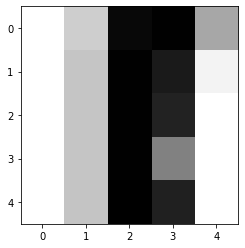

And the whole sample:


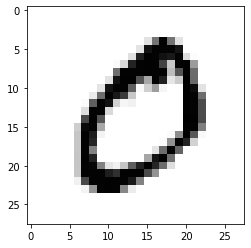

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [0]:
print('X_train [shape %s] sample patch:\n'
%(str(X_train.shape)),X_train[1,15:20,5:10])
print('A closeup of a sample patch')
plt.imshow(X_train[1,15:20,5:10],cmap='Greys')
plt.show()
print('And the whole sample:')
plt.imshow(X_train[1],cmap='Greys')
plt.show()
print('y_train [shape %s] 10 samples:\n'
%(str(y_train.shape)),y_train[:10])

In [0]:
X_train_flat=X_train.reshape((X_train.shape[0],-1))
print(X_train_flat.shape)
X_val_flat=X_val.reshape((X_val.shape[0],-1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [0]:
import keras
y_train_oh=keras.utils.to_categorical(y_train,10)
y_val_oh=keras.utils.to_categorical(y_val,10)
print(y_train_oh.shape)
print(y_train_oh[:3],y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
from keras import backend as K

def reset_tf_session():
  curr_session=tf.get_default_session()
  if curr_session is not None:
    curr_session.close()
  K.clear_session()
  config=tf.ConfigProto()
  config.gpu_options.allow_growth=True
  s=tf.InteractiveSession(config=config)
  K.set_session(s)
  return s

In [0]:
s = reset_tf_session()

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
W=tf.get_variable('W',shape=(784,10))
b=tf.get_variable('b',shape=(10,))

In [0]:
input_X=tf.placeholder(shape=(None,784),dtype='float32')
input_y=tf.placeholder(shape=(None,10),dtype='float32')

In [0]:
logits=tf.add(tf.matmul(input_X,W),b)
probas=tf.nn.softmax(logits)
classes=tf.argmax(probas,axis=1)
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y,logits=logits))
step=tf.train.AdamOptimizer().minimize(loss)

In [0]:
from IPython.display import clear_output,display_html,HTML
import contextlib
import time
import io
import urllib
import base64


def clear_and_display_figure(fig, sleep=0.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)

class SimpleTrainingCurves(object):
  def __init__(self,loss_name,metric_name):
    self.fig,(self.ax1,self.ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
    self.ax1.set_title(loss_name)
    self.ax2.set_title(metric_name)
    self.train_loss_curve,=self.ax1.plot([],[],'r',
                                         label='train',
                                         lw=2)
    self.valid_loss_curve,=self.ax1.plot([],[],'g',
                                         label='valid',
                                         lw=2)
    self.train_metric_curve,=self.ax2.plot([],[],'r',
                                           label='train',
                                           lw=2)
    self.valid_metric_curve,=self.ax2.plot([],[],'g',
                                           label='valid',
                                           lw=2)
    self.iter=0
    self.y_limits_1=[None,None]
    self.y_limits_2=[None,None]
    plt.close(self.fig)

  def _update_y_limits(self,limits,*values):
    limits[0]=min(list(values)+([limits[0]] if 
                                limits[0] else []))
    limits[1]=max(list(values)+([limits[1]] if
                                limits[1] else []))
  
  def _update_curve(self,curve,value,label):
    x,y=curve.get_data()
    curve.set_data(list(x)+[self.iter],list(y)+[value])
    curve.set_label('{}: {}'.format(label,value))

  def _set_y_limits(self,ax,limits):
    spread=limits[1]-limits[0]
    ax.set_ylim(limits[0]-0.05*spread,limits[1]+0.05*spread)

  def add(self,train_loss,valid_loss,train_metric,valid_metric):
    self._update_curve(self.train_loss_curve,train_loss,
                       'train')
    self._update_curve(self.valid_loss_curve,valid_loss,
                       'valid')
    self._update_curve(self.train_metric_curve,train_metric,
                       'train')
    self._update_curve(self.valid_metric_curve,valid_metric,
                       'valid')
    self.ax1.set_xlim(0,self.iter)
    self.ax2.set_xlim(0,self.iter)
    self._update_y_limits(self.y_limits_1,train_loss,valid_loss)
    self._update_y_limits(self.y_limits_2,
                          train_metric,valid_metric)
    self._set_y_limits(self.ax1,self.y_limits_1)
    self._set_y_limits(self.ax2,self.y_limits_2)
    clear_and_display_figure(self.fig)
    #clear_output(wait=True)
    self.ax1.legend()
    self.ax2.legend()
    self.iter+=1


In [0]:
s.run(tf.global_variables_initializer())
BATCH_SIZE=512
EPOCHS=40

simpleTrainingCurves=SimpleTrainingCurves('cross-entropy',
                                          'accuracy')
batch_losses=[]
for epoch in range(EPOCHS):
  for batch_start in range(0,X_train_flat.shape[0],BATCH_SIZE):
    _,batch_loss=s.run([step,loss],{input_X:
                                    X_train_flat[
                                    batch_start:batch_start+
                                    BATCH_SIZE
                                    ],
                                    input_y:y_train_oh[
                                    batch_start:batch_start+
                                    BATCH_SIZE
                                    ]})
    batch_losses.append(batch_loss)
  train_loss=np.mean(batch_loss)
  val_loss=s.run(loss,{input_X:X_val_flat,
                       input_y:y_val_oh})
  train_accuracy=accuracy_score(y_train,s.run(classes,
                                              {input_X:
                                               X_train_flat}))
  valid_accuracy=accuracy_score(y_val,s.run(classes,
                                            {input_X:
                                             X_val_flat}))
  simpleTrainingCurves.add(train_loss,val_loss,train_accuracy,
                           valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuN%2BOP7QHwm/Zx8JW/jT4veJ5dPtL7U4dN0u2stLub%2B91K9lDGO1tLO0jluLudlR2EUMbvtR2xhWI7KvFv2u/gP8VPiX4h%2BGfxl%2BBd14fl8X/CrxjPrWmaJ4tu57bTdYhudLvdMubaW4ghmktH8q9aSOdYZtrR7TGyu2ACjpH/AAUr/Y71rxm3w8tvHviCDW7fSodU1bTtR%2BHOvWkmi2EhuAt3qXn2SDTIAbWcNLdmFEKYYqWUGbwn/wAFH/2NfGfg/wAQ%2BOtM%2BLFza6f4Y0e11fVBrnhPVdMuJNPuXMdreWtvd2sU19bzyAxwy2ySpM5CRlmIB86vP2GPjP8AHW0/aRP7Qt74V8My/tB/CPTvBskfgrWLrUzo7RWusWsr%2BbcWtqZ1VNRiZDsXeyygogxuy9Y/Y2/at%2BM%2Btaz8UP2lPh38G9X1e0%2BE6eBtB8E6d4n1QaRrSy6jaXt5fXd2bBJ9PYmyg%2BzxQw3BtnDP50hIwAeyX/7fP7N2k%2BAbH4h6tdeOLSHVPED6Jpeh3Xwj8SR67e3yW5uXjh0dtPGoShYAZTIluUCKzFsA49P8JeOfDfjbwTY/EPRbi5i0rULBbyCTVNPnsZY4iu7MsFykcsDAfeSRVZSCGAIIr41tv2Gf2tJfgpJ4W8feGPCnjS%2Bh%2BIcut%2BC9B1n9ofxXb3fgOxOmxWoi0/xbHp7atcSGUXcreZDGBHeGENsjGfUvB/7Bmq%2BKfgJo3hb9pz46%2BOPEfj5PhtdeFtf8Q6T8Q9at9Muhc2tzbyTPpa3SWN5MiXTBbq4tmmdoopWKuibADc8Mf8FJP2MvF/h7xJ4s0b4tXK6Z4W8GXni6/vr7wlqtpFe6BaruuNU09p7VBqtogK5nsvPQmSMAkyIG4n40f8FdP2YfAf7M/wATf2gfhW%2Bs%2BM7v4b%2BDYfEjeGW8L6xps2r2Nw7R2t3avNYFrixlkRh9vgjmtkVWdnCqSPHfC/8AwSh%2BNC/BPxf8LPFnh3w9J4h/4UL4j8A%2BC/Hmo/tD%2BNvECSXGpWEdp5h0jVUkttGtpDDE8scEl0yeVGqFggz6P%2B1L/wAE5vih%2B0BYeKtE0Pxj4d0q2179le%2B%2BGlrLM87GDVpLiOWGdo1iANqNhBIbzBnhO9AHqkv/AAUU/ZZt/E3hrwJeav41tvEni7TpdQ0HwpefCTxLDq8tnFd/Y5LmSwk08XNvCkxG6SaNEVGWUkRsrmXwN/wUT/Y7%2BJGqarpXhD4tyXB0rQ9Q1lbufw1qVvaapp1iwS8u9NuZrdYdVhhYqHeyedVLqCfmGcXwR8APjz4x/apsf2oPjn4f8HeH5JPg5f8Ag/VNE8J%2BK7vVTBcy6tHcpJDcz6fZl4mgiUsTGjJIdoV1USHwGb9hz9pf4bfs8%2BF/Cnxo1rwIPCP7N3wP8SaB4L1PwrfXcmpeKd2hHTLe4vbeW2ii04JZozSQxS3QknZXDxqgQgH0D4U/4Kl/sL%2BNPBus/ELQ/jLdrouheDj4tutRv/BmsWcdzoIKB9Vs/PtEN/ZxmRBJPbCWOLcPMZc167a/GD4c3vxcuPgVZ%2BIxN4qtPDUGv3emRWsrCHTp55beGd5QnlL5ksE6ohfe3kyEKQjEfFX7I/7P3xC8WfBL4Q/Hb9t/Uvhlovww%2BG/7L9z4fgk07W5wmr6bqmnaWby%2B1X7VBDDpkEVppyq0CS3CZleRplWNVrsP%2BCK3wr8d6P8As76n8evit4tbxFrHjW%2Bg03w54hlgaOS%2B8I6JF/ZWiXBD8/6VDDNqhPd9WcgKCFAB9lUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJCtu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVx37Qfxm0

In [0]:
print(s.run([classes],{input_X:X_val_flat[50:55]}))
print(y_val[50:55])

[array([4, 1, 6, 9, 8])]
[4 1 2 9 8]


In [0]:
hidden1=tf.layers.dense(input_X,256,
                        activation=tf.nn.sigmoid)
hidden2=tf.layers.dense(hidden1,256,
                        activation=tf.nn.sigmoid)
logits=tf.layers.dense(hidden2,10)
probas=tf.nn.softmax(logits)
classes=tf.argmax(probas,axis=1)

loss=tf.reduce_mean(tf.nn.
                    softmax_cross_entropy_with_logits(
                        labels=input_y,logits=logits
                    ))
step=tf.train.AdamOptimizer().minimize(loss)

In [133]:
s.run(tf.global_variables_initializer())
BATCH_SIZE=512
EPOCHS=40

simpleTrainingCurves=SimpleTrainingCurves('cross-entropy',
                                          'accuracy')
batch_losses=[]
for epoch in range(EPOCHS):
  for batch_start in range(0,X_train_flat.shape[0],BATCH_SIZE):
    _,batch_loss=s.run([step,loss],{input_X:
                                    X_train_flat[
                                    batch_start:batch_start+
                                    BATCH_SIZE
                                    ],
                                    input_y:y_train_oh[
                                    batch_start:batch_start+
                                    BATCH_SIZE
                                    ]})
    batch_losses.append(batch_loss)
  train_loss=np.mean(batch_loss)
  val_loss=s.run(loss,{input_X:X_val_flat,
                       input_y:y_val_oh})
  train_accuracy=accuracy_score(y_train,s.run(classes,
                                              {input_X:
                                               X_train_flat}))
  valid_accuracy=accuracy_score(y_val,s.run(classes,
                                            {input_X:
                                             X_val_flat}))
  simpleTrainingCurves.add(train_loss,val_loss,train_accuracy,
                           valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuN%2BOP7QHwm/Zx8JW/jT4veJ5dPtL7U4dN0u2stLub%2B91K9lDGO1tLO0jluLudlR2EUMbvtR2xhWI7KvFv2u/gP8VPiX4h%2BGfxl%2BBd14fl8X/CrxjPrWmaJ4tu57bTdYhudLvdMubaW4ghmktH8q9aSOdYZtrR7TGyu2ACjpH/AAUr/Y71rxm3w8tvHviCDW7fSodU1bTtR%2BHOvWkmi2EhuAt3qXn2SDTIAbWcNLdmFEKYYqWUGbwn/wAFH/2NfGfg/wAQ%2BOtM%2BLFza6f4Y0e11fVBrnhPVdMuJNPuXMdreWtvd2sU19bzyAxwy2ySpM5CRlmIB86vP2GPjP8AHW0/aRP7Qt74V8My/tB/CPTvBskfgrWLrUzo7RWusWsr%2BbcWtqZ1VNRiZDsXeyygogxuy9Y/Y2/at%2BM%2Btaz8UP2lPh38G9X1e0%2BE6eBtB8E6d4n1QaRrSy6jaXt5fXd2bBJ9PYmyg%2BzxQw3BtnDP50hIwAeyX/7fP7N2k%2BAbH4h6tdeOLSHVPED6Jpeh3Xwj8SR67e3yW5uXjh0dtPGoShYAZTIluUCKzFsA49P8JeOfDfjbwTY/EPRbi5i0rULBbyCTVNPnsZY4iu7MsFykcsDAfeSRVZSCGAIIr41tv2Gf2tJfgpJ4W8feGPCnjS%2Bh%2BIcut%2BC9B1n9ofxXb3fgOxOmxWoi0/xbHp7atcSGUXcreZDGBHeGENsjGfUvB/7Bmq%2BKfgJo3hb9pz46%2BOPEfj5PhtdeFtf8Q6T8Q9at9Muhc2tzbyTPpa3SWN5MiXTBbq4tmmdoopWKuibADc8Mf8FJP2MvF/h7xJ4s0b4tXK6Z4W8GXni6/vr7wlqtpFe6BaruuNU09p7VBqtogK5nsvPQmSMAkyIG4n40f8FdP2YfAf7M/wATf2gfhW%2Bs%2BM7v4b%2BDYfEjeGW8L6xps2r2Nw7R2t3avNYFrixlkRh9vgjmtkVWdnCqSPHfC/8AwSh%2BNC/BPxf8LPFnh3w9J4h/4UL4j8A%2BC/Hmo/tD%2BNvECSXGpWEdp5h0jVUkttGtpDDE8scEl0yeVGqFggz6P%2B1L/wAE5vih%2B0BYeKtE0Pxj4d0q2179le%2B%2BGlrLM87GDVpLiOWGdo1iANqNhBIbzBnhO9AHqkv/AAUU/ZZt/E3hrwJeav41tvEni7TpdQ0HwpefCTxLDq8tnFd/Y5LmSwk08XNvCkxG6SaNEVGWUkRsrmXwN/wUT/Y7%2BJGqarpXhD4tyXB0rQ9Q1lbufw1qVvaapp1iwS8u9NuZrdYdVhhYqHeyedVLqCfmGcXwR8APjz4x/apsf2oPjn4f8HeH5JPg5f8Ag/VNE8J%2BK7vVTBcy6tHcpJDcz6fZl4mgiUsTGjJIdoV1USHwGb9hz9pf4bfs8%2BF/Cnxo1rwIPCP7N3wP8SaB4L1PwrfXcmpeKd2hHTLe4vbeW2ii04JZozSQxS3QknZXDxqgQgH0D4U/4Kl/sL%2BNPBus/ELQ/jLdrouheDj4tutRv/BmsWcdzoIKB9Vs/PtEN/ZxmRBJPbCWOLcPMZc167a/GD4c3vxcuPgVZ%2BIxN4qtPDUGv3emRWsrCHTp55beGd5QnlL5ksE6ohfe3kyEKQjEfFX7I/7P3xC8WfBL4Q/Hb9t/Uvhlovww%2BG/7L9z4fgk07W5wmr6bqmnaWby%2B1X7VBDDpkEVppyq0CS3CZleRplWNVrsP%2BCK3wr8d6P8As76n8evit4tbxFrHjW%2Bg03w54hlgaOS%2B8I6JF/ZWiXBD8/6VDDNqhPd9WcgKCFAB9lUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJCtu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeL/H

In [134]:
print(s.run([classes],{input_X:X_val_flat[50:55]}))
print(y_val[50:55])

[array([4, 1, 2, 9, 8])]
[4 1 2 9 8]
